In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import  Variable
import torchvision
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import os

In [2]:
channels = 3
IMG_SIZE = 32
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

In [3]:
DATA_PATH = { "train": "data/train", 
              "test": "data/test",
             "label_names" : "data/batches.meta"}

In [4]:
# Load label names
with open(DATA_PATH["label_names"], 'rb') as fo:
    c = pickle.load(fo, encoding='bytes')
CLASSES = [str(i,'utf-8') for i in c[b"label_names"]]
NUM_CLASSES = len(CLASSES)

In [5]:
# Load CIFAR dataset
def unpickle():
    print("Loading data...")
    filename = os.listdir(DATA_PATH["train"])
    imgs = []
    labels = []
    
    for i in filename:
        path = os.path.join(DATA_PATH["train"],i)
        with open(path, 'rb') as fo:
            d = pickle.load(fo, encoding='bytes')
            imgs.append(d[b"data"])
            labels += d[b"labels"]
    print("Data loaded!")
    return np.array(imgs).reshape(-1,channels,IMG_SIZE,IMG_SIZE), np.array(labels)

imgs, labels = unpickle()

Loading data...
Data loaded!


In [6]:
print(f"Number of training samples: {len(labels)}")
print(f"Number of unique labels : {NUM_CLASSES}")
print(f"Unique labels name: \n{CLASSES}")

Number of training samples: 50000
Number of unique labels : 10
Unique labels name: 
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


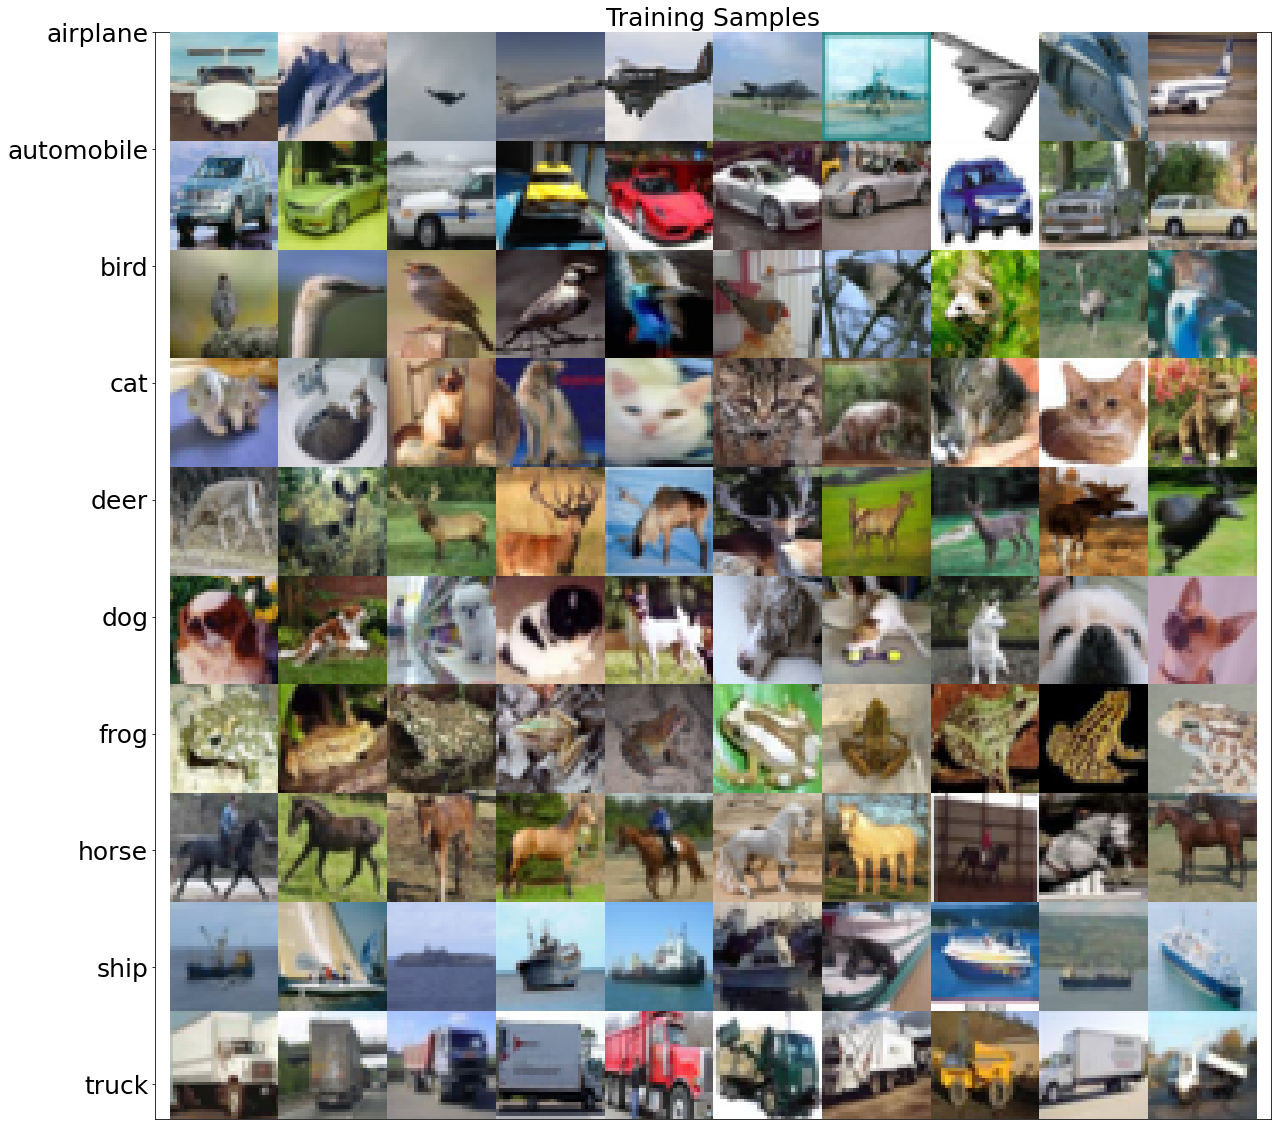

In [7]:
# Visualize some training samples
from mpl_toolkits.axes_grid1 import ImageGrid

def visualize_samples(NUM_PIC=10):
    a = np.random.randint(100-NUM_PIC)
    fig = plt.figure(figsize=(NUM_PIC*2,NUM_PIC*2))
    plt.title("Training Samples", fontsize=25)
    plt.xticks([])
    plt.yticks(np.arange(10)[-1:-11:-1]+0.3, CLASSES, fontsize=25)
    grid = ImageGrid(fig, 111, (NUM_PIC,NUM_PIC), axes_pad=0)
    
    imgs_id_list = []
    for i in range(10):
        imgs_id = np.where(labels == i)
        imgs_id_list += list(imgs_id[0][a:a+NUM_PIC])
    
    for ax, im_id in zip(grid, imgs_id_list):
        img = imgs[im_id]
        ax.imshow(img.transpose((1,2,0)))
        ax.axis("off")
    
    
    plt.show()
    
    
visualize_samples()

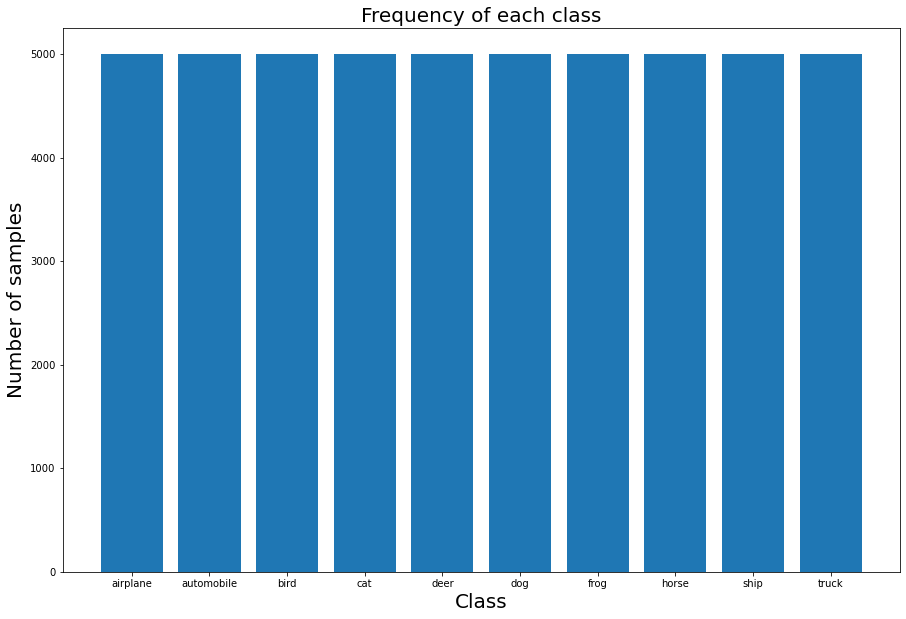

In [8]:
def visualize_frequency():
    id_count = {CLASSES[i]: len(np.where(labels == i)[0]) for i in range(10)}

    fig = plt.subplots(figsize=(15,10))
    plt.bar(id_count.keys(), height=id_count.values())
    plt.title("Frequency of each class", fontsize= 20)
    plt.xlabel("Class", fontsize= 20)
    plt.ylabel("Number of samples", fontsize= 20)
    plt.show()
    
visualize_frequency()    

In [9]:
# Load pretrained model

model = models.AlexNet(NUM_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
class CifarDataset():
    def __init__(self, tensor, labels, transforms = None, device = None):
        self.tensor = tensor
        self.labels = labels
        self.transforms = transforms
        self.device = device
        if self.transforms is not None:
            for t in range(self.tensor.size(0)):
                self.tensor[t] = self.transforms(self.tensor[t])
        
        if self.device is not None:
            self.tensor = self.tensor.to(device)
            self.labels = self.labels.to(device)
                
    def __getitem__(self, ids):
        return self.tensor[ids],self.labels[ids]
    
    def __repr__(self):
        dataset = data.TensorDataset(self.tensor,self.labels)
        return dataset
    
    def __str__(self):
        pass
    
    def __len__(self):
        return self.tensor.size(0)

In [11]:
img_tensor = torch.Tensor(imgs)
label_tensor = torch.Tensor(labels)

data_transform = transforms.Compose([
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

In [12]:
trainset = CifarDataset(img_tensor,label_tensor, data_transform, device)

In [13]:
BATCH_SIZE = 32
trainloader = data.DataLoader(trainset, batch_size=BATCH_SIZE, num_workers=0)

In [14]:
def train_step(epoch, model, optimizer, criterion, trainloader):
    model.train()
    total_loss = 0
    for i, (img,label) in enumerate(trainloader):
        optimizer.zero_grad()
        output = model(img).squeeze()
        loss = criterion(output,label)
        
        loss.backward()
        optimizer.step()
        total_loss+=loss.data
        if (i%100 == 0):
            print(f"Epoch: [{epoch+1}] | Iterations: [{i+1}|{len(trainloader)}] | Loss: {loss.data}")
    return model, total_loss

In [15]:
TRAIN_DATA = 1
if TRAIN_DATA:
    EPOCH = 5
    for epoch in range(EPOCH):
         model, train_loss = train_step(epoch, model, optimizer, criterion,trainloader)

RuntimeError: Given input size: (256x1x1). Calculated output size: (256x0x0). Output size is too small